In [64]:
from env import get_db_url
import numpy as np
import pandas as pd
import os
import acquire
import prepare
import wrangle
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import explore
import pydataset
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

###   Project Overview and Goals:
- Explore the enormous dataset to find patterns
- Organize features creating dummies for the fips code to represent Los Angeles, Orange, and Ventura Counties
- Run analysis to see what features are correlated/dependent to the target tax assessed value of the homes
- Try and determine which factors are driving price 
- Goal: To see if we can find the driving factors that can build a Robust Model

In [65]:
# Call the 2017 properties that were sold under the predictions_2017 table
zillow_predictions = wrangle.wrangle_zillow_predictions()
# Create zillow _categorical in order to show the fips visualizations
zillow_categorical = wrangle.wrangle_zillow_predictions_without_drop()
# Double check the nulls were handled
zillow_predictions.isna().sum()

bedrooms       0
bathrooms      0
sqft           0
tax_value      0
year_built     0
tax_amount     0
Los Angeles    0
Orange         0
Ventura        0
dtype: int64

### Initial split.  The mvp split will take out tax_amount but for exploration purposes I kept it in here.  Here are the features I settled with along with the target tax_value and its related tax_amount

In [66]:
#Initial split for explore

train, validate, test = wrangle.split_data(zillow_predictions)
train

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1959.0,4968.19,1,0,0
38332,2.0,1.0,1638.0,126907.0,1927.0,1500.66,1,0,0
32297,4.0,2.0,1725.0,592000.0,1966.0,7380.59,1,0,0
31139,2.0,1.0,1015.0,172499.0,1925.0,2252.18,1,0,0
20188,1.0,1.0,565.0,292368.0,1915.0,3624.67,1,0,0
...,...,...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,1959.0,6464.74,0,0,1
8268,3.0,2.0,1534.0,380623.0,1970.0,4731.33,1,0,0
2175,2.0,1.5,1213.0,431697.0,1956.0,5451.26,0,1,0
11049,3.0,2.0,1584.0,271747.0,1959.0,3386.08,1,0,0


## Pearson Correlation

###  Done for every column against every other column
#### Meta Null Hypothesis:  There is no relation between column a and column b  
#### Meta Alternative Hypothesis:  There is a relation between column a and column b  
#### alpha < 0.01

In [67]:
# for col in train.columns:
#     for col2 in train.columns:
#         if col == col2:
#             continue
#         else:
#             stat, p = stats.pearsonr(train[col], train[col2])
#             print(f'{col} and {col2}: {stat}, {p}')

### As expected there are a lot of correlations here but the top three rows provide a good sanity check.  Los angeles, Orange, and Ventura counties should have no correlation with each other and tax_amount and tax_value have a near perfect correlation.

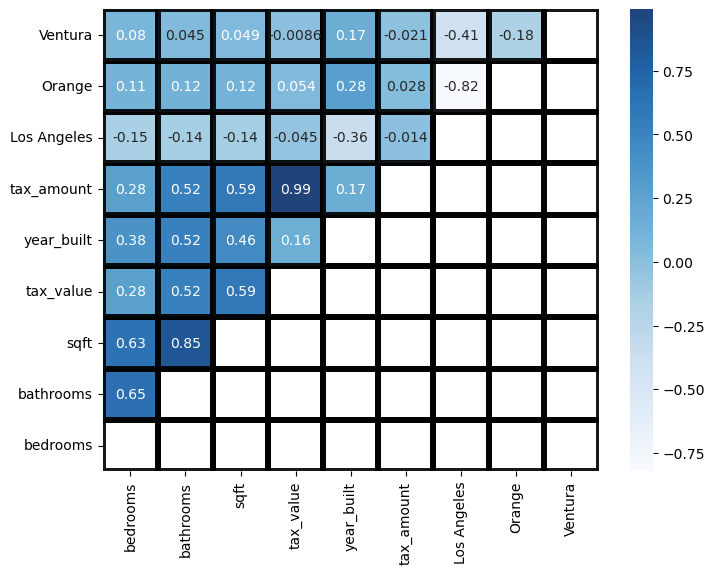

In [68]:
# Correlation Graphic
explore.correlation_heatmap(train)

<Axes: xlabel='tax_amount', ylabel='tax_value'>

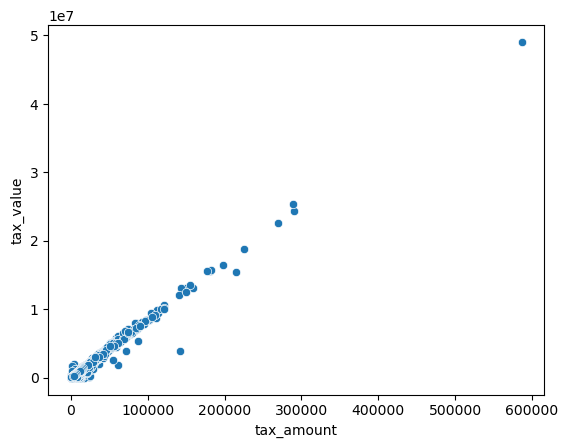

In [69]:
#potential data leakage
sns.scatterplot(train, x='tax_amount', y='tax_value')

### Tax amount was taken out of the mvp dataset as the correlation is indicative of the fact that there would be data leakage otherwise.  Real world tax amounts are calculated from tax assesment values.

##  Create mvp datasets

### Resplit for mvp without tax_amount and automatic feature selection.  For MVP I decided to keep all the other features in.

In [70]:
X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, X_test_mvp, y_test_mvp = explore.mvp_split(train, validate, test)

print(explore.select_kbest(X_train_mvp, y_train_mvp, n=3))
print(explore.rfe(X_train_mvp, y_train_mvp, n=3))

3 selected features
['bedrooms', 'bathrooms', 'sqft']
None
3 selected features
['Los Angeles', 'Orange', 'Ventura']
None


In [71]:
X_train_mvp

,bedrooms,bathrooms,sqft,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,1,0,0
38332,2.0,1.0,1638.0,1,0,0
32297,4.0,2.0,1725.0,1,0,0
31139,2.0,1.0,1015.0,1,0,0
20188,1.0,1.0,565.0,1,0,0
...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,0,0,1
8268,3.0,2.0,1534.0,1,0,0
2175,2.0,1.5,1213.0,0,1,0
11049,3.0,2.0,1584.0,1,0,0


## Baseline

In [72]:
y_train_mvp, y_validate_mvp, y_test_mvp, rmse_train_mvp_median, rmse_validate_mvp_median = explore.baseline_rmse(y_train_mvp, y_validate_mvp, y_test_mvp)

RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99


## Linear Regression

In [73]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_lm, rmse_validate_mvp_lm = explore.linear_regression(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

RMSE for OLS using LinearRegression
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010334001


## LassoLars

In [74]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_lars, rmse_validate_mvp_lars = explore.lasso_lars(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

RMSE  using LassoLars
Training/In-Sample:  612017.8219824053 
Validation/Out-of-Sample:  582749.4938726074 \With alpha= 10


## Quadratic Regression

In [75]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_quad, rmse_validate_mvp_quad, rmse_test_mvp_quad = explore.quadratic_regression(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, X_test_mvp, y_test_mvp)

RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  552256.3705779964 
Validation/Out-of-Sample:  562682.7144393248


In [76]:
# metrics in a dataframe

results = explore.metrics(rmse_train_mvp_median, rmse_validate_mvp_median, rmse_train_mvp_lm, rmse_validate_mvp_lm, rmse_train_mvp_lars, rmse_validate_mvp_lars, rmse_train_mvp_quad, rmse_validate_mvp_quad)

In [77]:
results = results.set_index(['model']).drop(columns=['RMSE_train','RMSE_validate'])

In [78]:
results

,R2_train,R2_validate
model,,
mean_baseline,0.000000,0.000000
Linear Regression,0.222133,0.259333
LassoLars alpha=10,0.222133,0.259333
Quadratic Regression,0.298089,0.284838


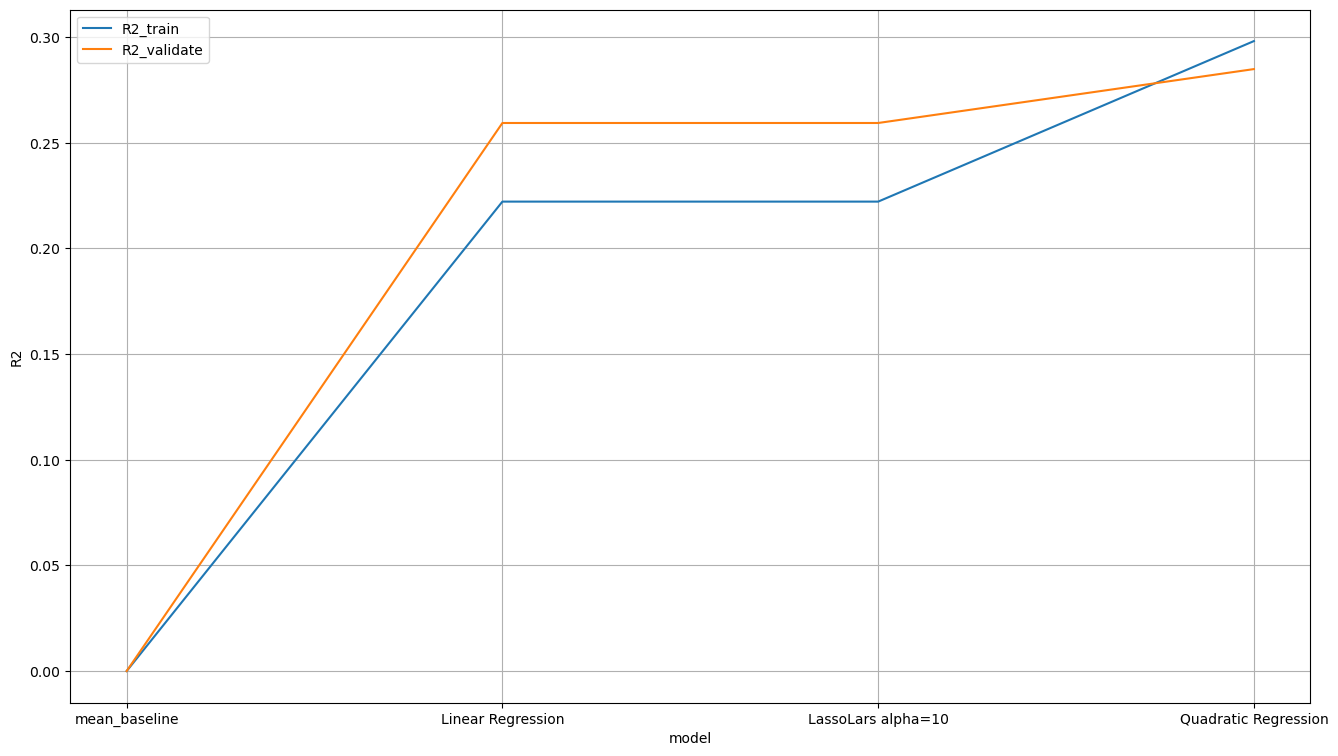

In [79]:

#PLOT the data
results.plot(figsize=(16,9))
plt.ylabel('R2')
plt.xticks(np.arange(0,4,1))
plt.grid()
plt.show()

In [80]:
print("RMSE for Quadratic Model \nTest: ", rmse_test_mvp_quad)

RMSE for Quadratic Model 
Test:  487522.2954864461


In [81]:
print("R2 for Quadratic Model: ", (rmse_train_mvp_median - rmse_test_mvp_quad) / rmse_train_mvp_median)

R2 for Quadratic Model:  0.38036563852638405


##  Conclusion

### This model is a great start however it is no where near viable:  With a median home price of  786,790 an RMSE of 487,522 is not really helpful.  We need to explore more features and how they are interrelated.  For instance:

### These graphs are from zillow_predictions without dummy variables for fips

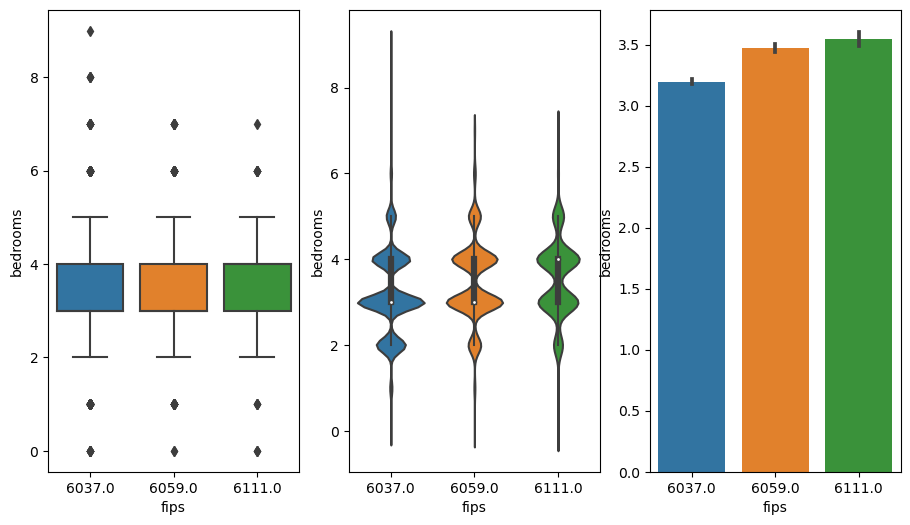

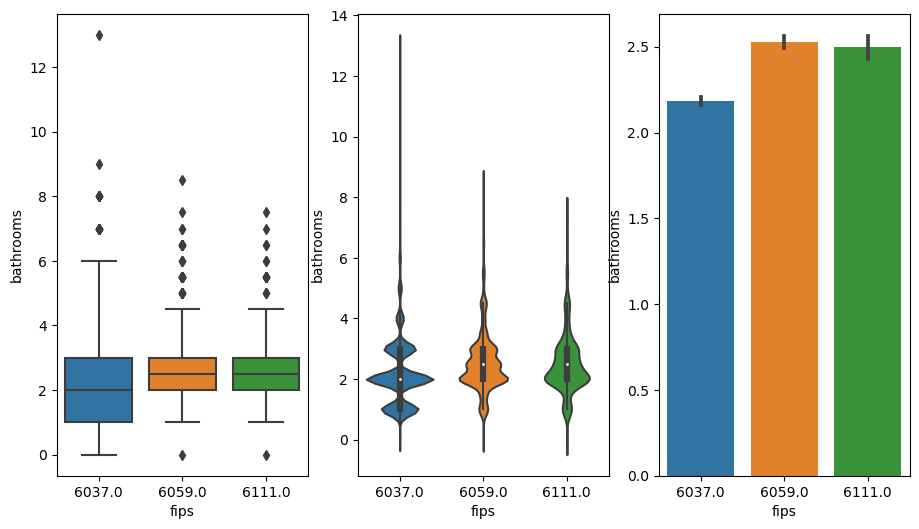

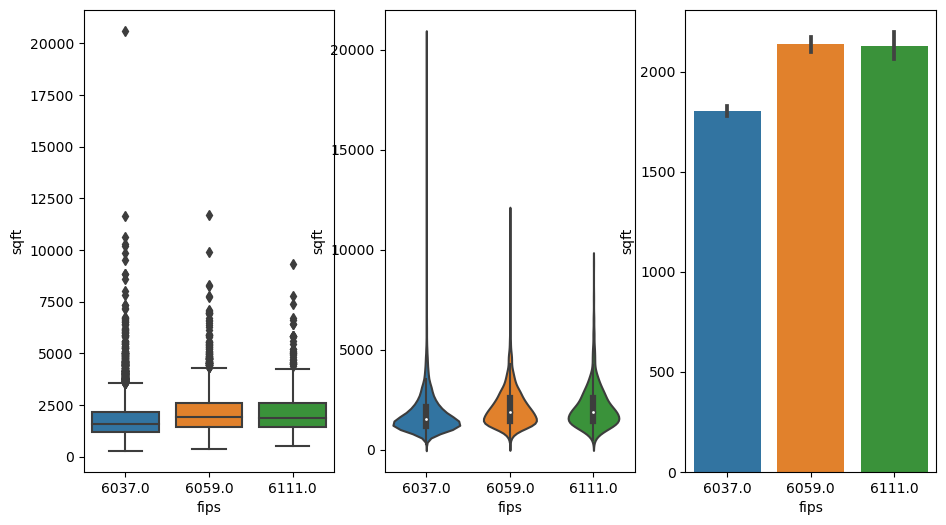

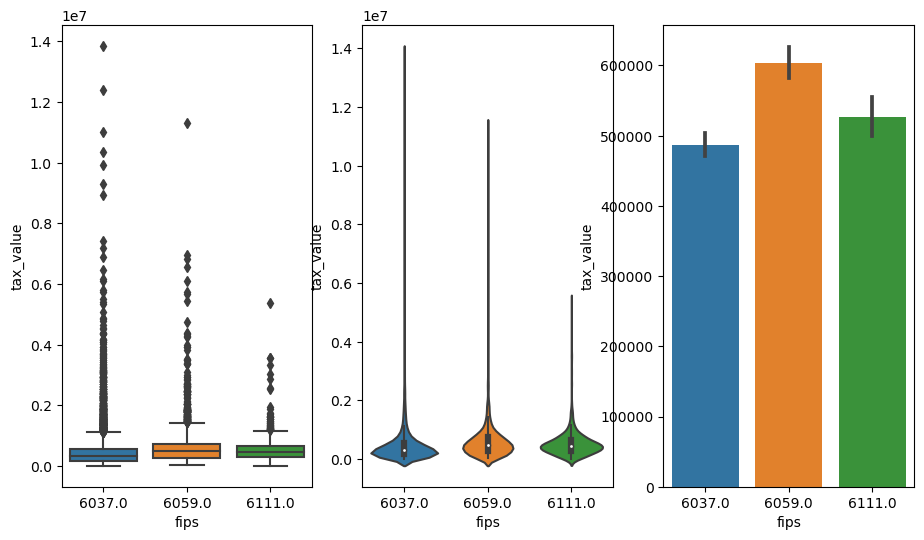

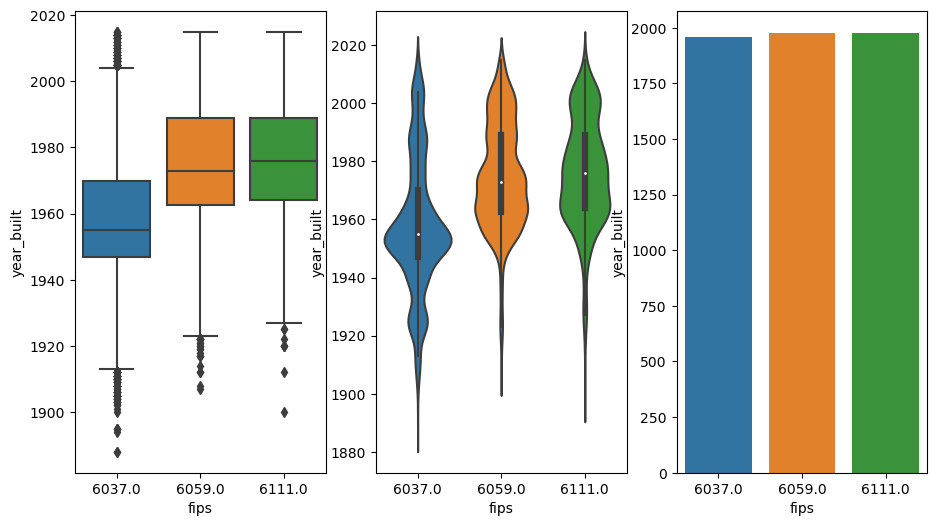

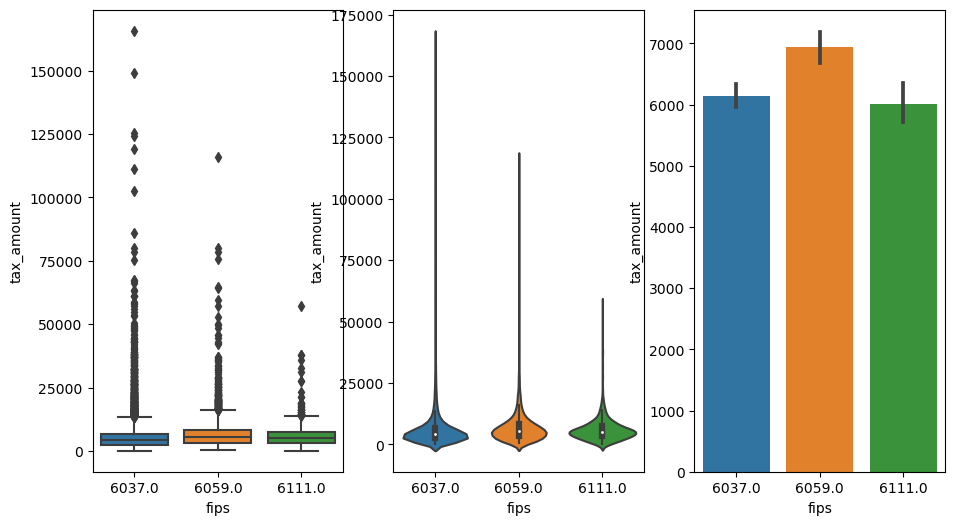

In [82]:
explore.plot_categorical_and_continuous_vars(zillow_categorical, sample_size=10000)

### There is clearly something fundamentally different about Los Angeles:

### Quick Chi Squared as an example treating year built as a categorical:
Null Hypothesis:  There is no difference between zip codes as it pertains to year built
Alt Hypothesis: There is a difference between zip codes as it pertains to year built
alpha < 0.01

In [83]:
#Create the dataframe
col = pd.crosstab(zillow_categorical['year_built'], zillow_categorical['fips'])
#Run chi squared on year built vs county
col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
print(f'(chi squared = {col_chi2}, p = {col_p}')
print('___________________________________________________________')


(chi squared = 12975.477017572226, p = 0.0
___________________________________________________________


### As we can see we can reject the null and see on just this one metric there is a significant difference between the zip codes and when these homes were bult.  What does this mean?  What is going on?